In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from copy import deepcopy
import pandas as pd
from sklearn.linear_model import LinearRegression
from random import sample
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Ransac:
  def __init__(self,max_trials=100,
         min_sample=50,
         loss='absolute_loss',
         residual_threshold=5.0,
         random_state=0):
    self.max_trials=max_trials
    self.min_sample=min_sample
    self.loss=loss
    self.residual_threshold=residual_threshold
    self.random_state=random_state
    self.bestScore=1e9
    self.bestModel = None
    self.inlier_mask_ = None

  def fit(self, X, y):
    lr = LinearRegression()
    if self.min_sample > X.shape[0]:
        self.min_sample = X.shape[0]
    sampleSize = X.shape[0]
    samples = np.arange(sampleSize)

    for n in range(1,self.max_trials+1):
      # 1. select a random number of examples to be inliers and fit the model
      sample(range(sampleSize), self.min_sample)
      Xinliers = X[samples]
      yinliers = y[samples]
      lr.fit(Xinliers,yinliers)

      # 2. test all other data points against the fitted model and add those
      # points that fall within a user-given tolerance to the inliers
      ypredict = lr.predict(X)
      residuals = abs(ypredict-y)
      inliers = residuals < self.residual_threshold

      # 3. refit the model using all inliers
      lr.fit(X[inliers],y[inliers])
      ypredict = lr.predict(X[inliers])
      # 4. estimate the error of the fitted model versus the inliers
      score = mae(y[inliers],ypredict)
      if score < self.bestScore:
          self.bestScore = score
          self.bestModel = deepcopy(lr)
          self.inlier_mask_ = inliers
    return self

  def predict(self,X):
    return self.bestModel.predict(X)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
X = df[['RM']].values
y = df['MEDV'].values
ransac = Ransac()
ransac.fit(X,y)

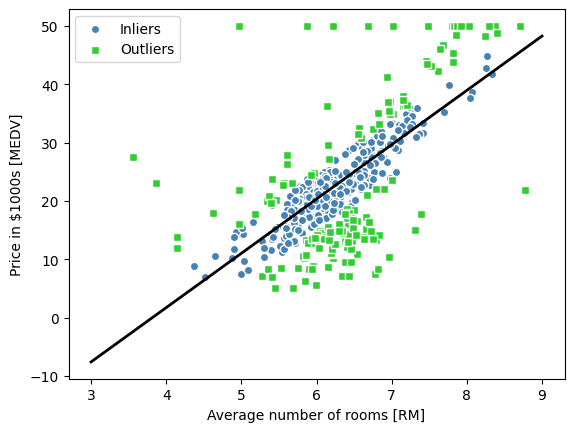

In [ ]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

In [ ]:
print('Slope: %.3f' % ransac.bestModel.coef_[0])
print('Intercept: %.3f' % ransac.bestModel.intercept_)

Slope: 9.311
Intercept: -35.541
